## Imports

In [1]:
import os, sys, joblib, json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from IPython.display import clear_output
lib_path = './../Sources'
if (lib_path not in sys.path):
    sys.path.append(lib_path) #src directory
from lpsrec.messaging.print_functions import ProgressBar
from lpsrec.messaging.telegrambot import Bot
import lpsrec.database as db
%matplotlib inline 

## Parameters

In [2]:
dataset_tag = 'AMZIV'
model_tag = 'OS'
bot_alive = False

In [3]:
# Creating output folders
dataset_output_folder = os.path.join('.', 'Outputs', dataset_tag)
variables_output_folder = os.path.join(dataset_output_folder, model_tag, 'Variables')
figures_output_folder = os.path.join(dataset_output_folder, model_tag, 'Figures')
if not os.path.exists(variables_output_folder):    
    os.makedirs(variables_output_folder)    
if not os.path.exists(figures_output_folder):        
    os.makedirs(figures_output_folder)

In [4]:
style_dict = json.load(open('./style_dict.json', 'r'))
plt.rc('font', **style_dict['font'])
# plt.rc('axes.titlesize', fontsize=20)
plt.rc('xtick', labelsize=style_dict['tick']['fontsize']) 
plt.rc('ytick', labelsize=style_dict['tick']['fontsize']) 

In [5]:
progbar = ProgressBar(bar_length=20, bar_fill='#', elapsed_time=True)
bot = Bot(user_credentials='./JFGS.json')
# # Checking if bot is ok
bot.send_message(text="{}\nHello, John. Initiating sparsity analysis for the {} dataset".format('-'*20, dataset_tag)) if bot_alive else ''  

''

## Connecting to Database

In [6]:
username = 'postgres'
password = 'admin'
dbname = 'RecSys'
hostname = 'localhost:5432'
conn = db.get_database_connection(username, password, hostname, dbname)

## Getting Dataset

In [7]:
dataset_info = pd.read_sql(con= conn , sql="select * from datasets.dataset where version='{}'".format(dataset_tag))
training_ratio = float(pd.read_sql(con= conn , sql="select max(training_ratio) from sparsity.folder")['max'][0])
df_sparsity_cenario = pd.read_sql(con= conn , sql="select * from sparsity.cenario")
df_whole = db.get_dataset_from_sparsity(conn, dataset_tag=dataset_tag)
print ("Dataset {} (id_dataset = {}) with {} registers".format(dataset_info['name'][0], dataset_info['id_dataset'][0], df_whole.shape[0]))
print ("Number of sparsity cenarios: ", df_sparsity_cenario.shape[0])
print ("Training ratio: ", training_ratio)
df_sparsity_cenario.head()

Dataset Amazon Instant Video (id_dataset = 6) with 583933 registers
Number of sparsity cenarios:  1296
Training ratio:  0.7


,id_sparsity_cenario,uss,iss
0,10759,0.3,0.30
1,10760,0.3,0.32
2,10761,0.3,0.34
3,10762,0.3,0.36
4,10763,0.3,0.38


In [8]:
df_whole.tail()

,user,item,feedback_value,timestamp,id_user,id_item
583928,AZYKTSGSVUGEL,B004TJRCU4,5.0,2011-06-06 21:00:00,2522394,227398
583929,AZZPCG11X8OBJ,B0072C8ME0,5.0,2014-01-03 22:00:00,2522500,210575
583930,AZZQH2RG6KPTR,B004CTBG1W,1.0,2014-03-03 21:00:00,2522504,230227
583931,AZZSKEO8CQK1Y,B00DIXFXHQ,5.0,2013-08-04 21:00:00,2522507,225072
583932,AZZVNH8GIA19N,B00BW75MKI,4.0,2013-12-11 22:00:00,2522513,210511


## Getting Sparsity Information

In [9]:
sql_str = """select * from sparsity.get_dataset_uss('{}')""".format(dataset_tag)
df_users_uss = pd.read_sql(con= conn , sql=sql_str)
df_users_uss.sort_values(['uss'], ascending=False).head()

,id_user_dataset,uss,n_feedback,max_feedback,id_user
0,A00019103H5DUGXXX2UPR,0.99639,1,277,2095604
269517,A3DUBX6G6TOKQF,0.99639,1,277,2365121
269526,A3DUEQ9U25VQ31,0.99639,1,277,2365130
269525,A3DUEPZ1CXUF0S,0.99639,1,277,2365129
269524,A3DUE0YTDJJXTY,0.99639,1,277,2365128


In [10]:
sql_str = """select * from sparsity.get_dataset_iss('{}')""".format(dataset_tag)
df_items_iss = pd.read_sql(con= conn , sql=sql_str)
df_items_iss.sort_values(['iss'], ascending=False).head()

,id_item_dataset,iss,n_feedback,max_feedback,id_item
23964,B00B5J9WAE,0.999921,1,12633,230471
8697,B000YDR43E,0.999921,1,12633,215204
19377,B00AB925J4,0.999921,1,12633,225884
19374,B004RHRDZC,0.999921,1,12633,225881
8701,B0085IX7SG,0.999921,1,12633,215208


In [11]:
uss_limits = df_sparsity_cenario['uss'].unique()
iss_limits = df_sparsity_cenario['iss'].unique()

In [12]:
%%time
counter = 0
df_overall_sparsity = pd.DataFrame(columns=['uss_limit', 'iss_limit', 'os', 'num_users', 'num_items'])

for uss_index, uss_limit in enumerate(uss_limits):
    progbar.update_progress(uss_index/float(len(uss_limits)-1))
    
    for iss_limit in iss_limits:
        # Filtering users/items with lower specific sparsity than the limit 
        users_ids = np.array(df_users_uss[df_users_uss['uss'] <= uss_limit]['id_user'])
        items_ids = np.array(df_items_iss[df_items_iss['iss'] <= iss_limit]['id_item'])

        df_filtered = df_whole[df_whole['id_user'].isin(users_ids)].reset_index(drop = True)
        df_filtered = df_filtered[df_filtered['id_item'].isin(items_ids)].reset_index(drop = True)

        # Calculating Overall Sparsity
        if (df_filtered.shape[0] == 0):
            text = "ERROR: dataset with 0 rows"
            bot.send_message(text=text)        
            print (text)
            break
        
        overall_sparsity = 1-df_filtered.shape[0]/float(len(df_filtered['id_user'].unique())*len(df_filtered['id_item'].unique()))        
        df_overall_sparsity.loc[counter] = [uss_limit, iss_limit, overall_sparsity, len(users_ids), len(items_ids)]        
        counter += 1

text = "Finished creating sparsity datasets for {} in {}".format(dataset_tag, progbar.get_elapsed_time())
bot.send_message(text=text) if bot_alive else ''         

[0:00:23][####################] 100.00% Done...
Wall time: 31.5 s


In [13]:
df_overall_sparsity.to_csv(os.path.join(variables_output_folder, 'df_overall_sparsity.tsv'), sep = '\t', header = True, index = False)
df_overall_sparsity.tail()

,uss_limit,iss_limit,os,num_users,num_items
1291,1.0,0.92,0.982808,426922.0,67.0
1292,1.0,0.94,0.988061,426922.0,98.0
1293,1.0,0.96,0.993415,426922.0,182.0
1294,1.0,0.98,0.996774,426922.0,384.0
1295,1.0,1.00,0.999943,426922.0,23965.0


## Generating USS and ISS analysis

In [14]:
df_overall_sparsity = pd.read_csv(os.path.join(variables_output_folder, 'df_overall_sparsity.tsv'), sep = '\t', header = 0)

In [15]:
df_users_uss.sort_values(['uss'], ascending=True).head()

,id_user_dataset,uss,n_feedback,max_feedback,id_user
136613,A27H9DOUGY9FOS,0.000000,277,277,2232217
411958,AV6QDP8Q0ONK4,0.133574,240,277,2507562
271194,A3EDIPCXT15C3T,0.234657,212,277,2366798
414867,AW3VZ5O895LRK,0.487365,142,277,2510471
372647,AIMR915K4YCN,0.548736,125,277,2468251


''

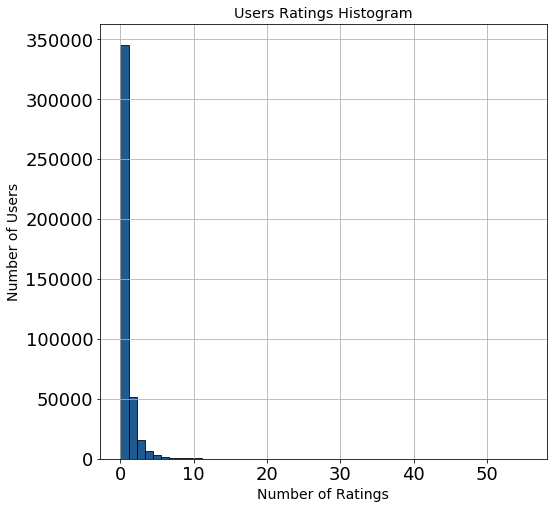

In [16]:
df_num_analysis = df_users_uss.sort_values(['uss'], ascending=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.grid(True)
ax.hist(df_num_analysis['n_feedback'], range=(0, 0.2*df_num_analysis['n_feedback'].max()), bins=50, linewidth=0.8, edgecolor='black', color=style_dict['lps-color'])
ax.set_title('Users Ratings Histogram')
ax.set_xlabel('Number of Ratings', fontsize=14)
ax.set_ylabel('Number of Users', fontsize=14)
filepath=os.path.join(figures_output_folder, 'users_ratings_histogram.png')
fig.savefig(filepath, bbox_inches = 'tight')
bot.send_message(filePath=filepath) if bot_alive else ''  

''

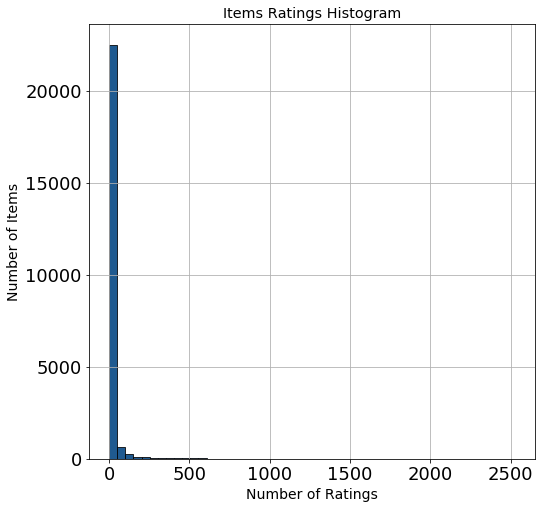

In [18]:
df_num_analysis = df_items_iss.sort_values(['iss'], ascending=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.grid(True)
ax.hist(df_num_analysis['n_feedback'], range=(0, 0.2*df_num_analysis['n_feedback'].max()), bins=50, linewidth=0.8, edgecolor='black', color=style_dict['lps-color'])
ax.set_title('Items Ratings Histogram')
ax.set_xlabel('Number of Ratings', fontsize=14)
ax.set_ylabel('Number of Items', fontsize=14)
filepath=os.path.join(figures_output_folder, 'items_ratings_histogram.png')
fig.savefig(filepath, bbox_inches = 'tight')
bot.send_message(filePath=filepath) if bot_alive else ''  

''

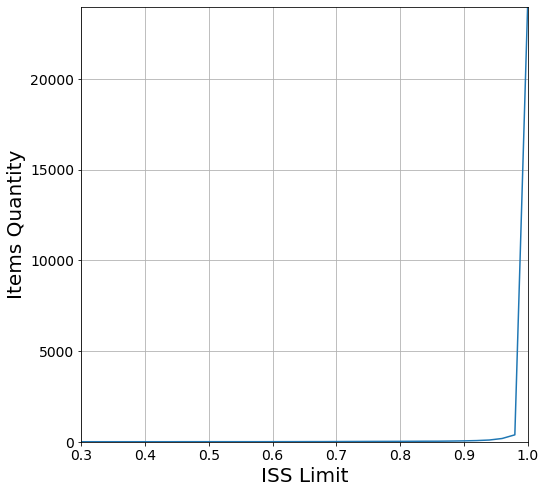

In [19]:
df_num_analysis = df_overall_sparsity.groupby(['iss_limit', 'num_items']).mean().reset_index()[['iss_limit', 'num_items', 'os']]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_num_analysis['iss_limit'], df_num_analysis['num_items'])
ax.axis([df_num_analysis['iss_limit'].min(), df_num_analysis['iss_limit'].max(), 0, df_num_analysis['num_items'].max()])
ax.grid(True)

ax.set_xticks([x/100.0 for x in np.arange (int(10*np.floor(10*df_num_analysis['iss_limit'].min())), 110, 10)])
ax.set_xlabel('ISS Limit', fontsize = 20)
ax.set_ylabel('Items Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Saving figure
filename = '2d-num_items_x_isslimit.png'
filepath = os.path.join(figures_output_folder, filename)
fig.savefig(filepath, bbox_inches = 'tight')
bot.send_message(filePath=filepath) if bot_alive else ''  

''

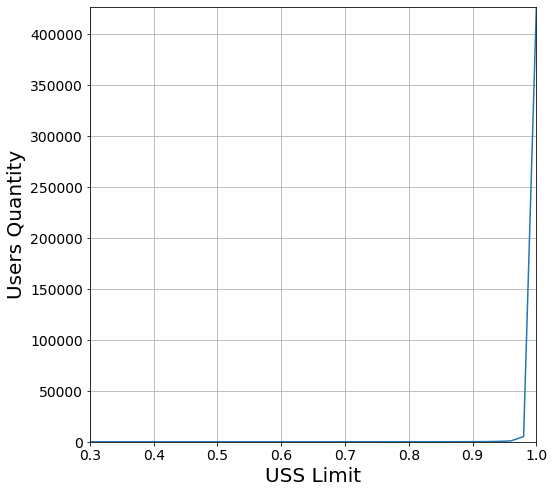

In [20]:
df_num_analysis = df_overall_sparsity.groupby(['uss_limit', 'num_users']).mean().reset_index()[['uss_limit', 'num_users', 'os']]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_num_analysis['uss_limit'], df_num_analysis['num_users'])
ax.axis([df_num_analysis['uss_limit'].min(), df_num_analysis['uss_limit'].max(), 0, df_num_analysis['num_users'].max()])
ax.grid(True)

ax.set_xticks([x/100.0 for x in np.arange (int(10*np.floor(10*df_num_analysis['uss_limit'].min())), 110, 10)])
ax.set_xlabel('USS Limit', fontsize = 20)
ax.set_ylabel('Users Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Saving figure
filepath = os.path.join(figures_output_folder, '2d-num_users_x_usslimit.png')
fig.savefig(filepath, bbox_inches = 'tight')
bot.send_message(filePath=filepath) if bot_alive else ''  

## Generating OS analysis

In [21]:
arr_os = np.zeros([len(uss_limits), len(iss_limits)])
for uss_index, uss_limit in enumerate(uss_limits):
    for iss_index, iss_limit in enumerate(iss_limits):
        arr_os[uss_index, iss_index] = df_overall_sparsity[(df_overall_sparsity['uss_limit'] == uss_limit) & (df_overall_sparsity['iss_limit'] == iss_limit)]['os'].reset_index(drop = True)[0]

joblib.dump(arr_os, os.path.join(variables_output_folder, 'arr_os.joblib'))        

['.\\Outputs\\AMZIV\\OS\\Variables\\arr_os.joblib']

In [22]:
arr_os = joblib.load(os.path.join(variables_output_folder, 'arr_os.joblib'))

''

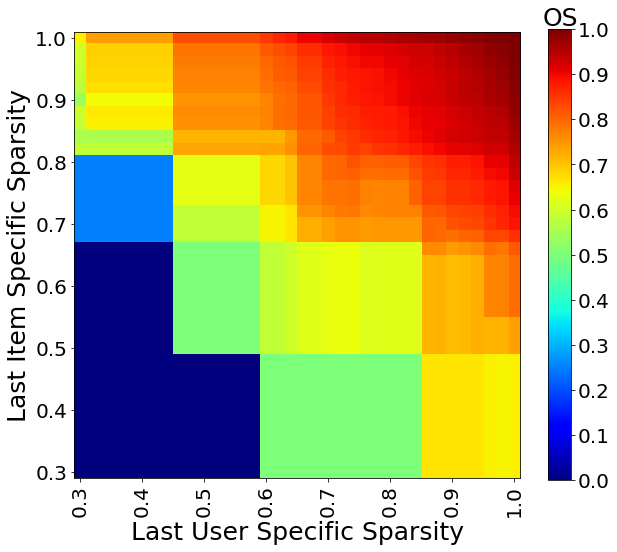

In [23]:
cmapping = "jet"
fig, ax = plt.subplots(figsize=(10,10))
cax = plt.imshow(arr_os, cmap=cmapping)
plt.gca().invert_yaxis()
cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,10)], shrink = 0.83)
tick_step = int(5)
ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])
plt.xticks(np.arange(0, len(uss_limits), tick_step))
plt.yticks(np.arange(0, len(iss_limits), tick_step))
plt.clim(0, 1)

tick_fontsize = 20
label_fontsize = 25

ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
# cbar = fig.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,5)])

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

filename = '2d-OS.png'
filepath = os.path.join(figures_output_folder, '2d-OS.png')
fig.savefig(filepath, bbox_inches = 'tight')
bot.send_message(filePath=filepath) if bot_alive else ''  

In [24]:
bot.send_message(text="End of analysis for the {} dataset\n{}".format(dataset_tag, '-'*20)) if bot_alive else ''

''

__________________